=== VWAP Strategy Backtest ===
Enter ticker symbol (e.g., SUNPHARMA.NS): POWERGRID.NS
Enter interval (e.g., 15m, 5m, 1h): 15m
Enter timeframe/period (e.g., 1d, 5d, 1mo): 60d

Processing POWERGRID.NS with 15m intervals for 60d period...
Processed columns: ['close', 'high', 'low', 'open', 'volume']
Data preprocessing completed successfully!
Data shape: (1435, 5)
Date range: 2025-07-14 09:15:00+05:30 to 2025-10-06 11:30:00+05:30

Initializing VWAP strategy...
Executing backtest...
Preparing indicators and signals...
Backtest complete.
Total trades: 37
Final capital: 99,900.00
Total return: -0.10%

BACKTEST PERFORMANCE SUMMARY
Initial Capital: $100,000.00
Final Capital: $99,900.00
Total P&L: $-100.00
Total Return: -0.10%
Total Trades: 37
Win Rate: 32.43%
Profit Factor: 0.60
Sharpe Ratio: -2.04
Max Drawdown: -0.16%

BACKTEST RESULTS DATAFRAME
 initial_capital  final_capital  total_pnl  total_return_pct  total_trades  winning_trades  losing_trades  win_rate_pct  profit_factor  sharpe_ratio  

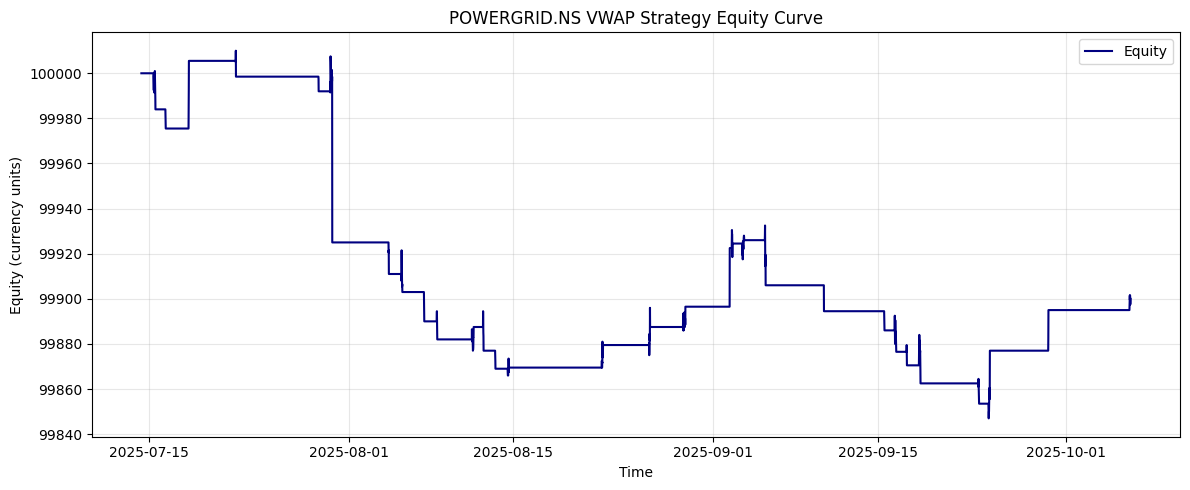


Backtest completed successfully for POWERGRID.NS!


In [ ]:
import yfinance as yf
import pandas as pd
import pytz
from intraday_vwap_strategy_beta import IntradayVWAPStrategy


def run_complete_vwap_backtest():
    """
    Complete VWAP backtest with data download, preprocessing, execution, and results display
    """

    # Get user inputs
    print("=== VWAP Strategy Backtest ===")
    ticker = input("Enter ticker symbol (e.g., SUNPHARMA.NS): ").strip().upper()
    interval = input("Enter interval (e.g., 15m, 5m, 1h): ").strip()
    period = input("Enter timeframe/period (e.g., 1d, 5d, 1mo): ").strip()

    print(f"\nProcessing {ticker} with {interval} intervals for {period} period...")
    print("Downloading and preprocessing data...")

    try:
        # Download the data
        data = yf.download(
            tickers=ticker,
            period=period,
            interval=interval,
            auto_adjust=True,
            progress=False
        )

        if data.empty:
            print(f"No data found for {ticker}. Please check the ticker symbol.")
            return None, None, None, None

        # Convert timestamps to IST
        ist = pytz.timezone('Asia/Kolkata')
        data.index = data.index.tz_convert(ist)

        # FIX: Proper column handling for single ticker
        if isinstance(data.columns, pd.MultiIndex):
            # For single ticker: extract only the first level (OHLCV names)
            data.columns = [col[0] for col in data.columns.values]

        # Standardize column names to lowercase
        data.columns = data.columns.str.lower()

        # Debug: Show actual column names
        print(f"Processed columns: {data.columns.tolist()}")

        print("Data preprocessing completed successfully!")
        print(f"Data shape: {data.shape}")
        print(f"Date range: {data.index[0]} to {data.index[-1]}")

        # Verify required columns exist
        required_cols = ['high', 'low', 'open', 'close', 'volume']
        missing_cols = [col for col in required_cols if col not in data.columns]

        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            print(f"Available columns: {data.columns.tolist()}")
            return None, None, None, None

        # Create and run strategy
        print("\nInitializing VWAP strategy...")
        strategy = IntradayVWAPStrategy(
            df=data,
            initial_capital=100000,
            max_risk_per_trade=2.0
        )

        print("Executing backtest...")
        tradebook_df, equity_curve_df = strategy.execute_intraday_backtest(verbose=True)

        # Get performance metrics and results
        metrics = strategy.get_performance_metrics()
        results_df = strategy.get_backtest_results()

        # Display comprehensive results
        print("\n" + "="*60)
        print("BACKTEST PERFORMANCE SUMMARY")
        print("="*60)

        if not results_df.empty:
            print(f"Initial Capital: ${results_df['initial_capital'].iloc[0]:,.2f}")
            print(f"Final Capital: ${results_df['final_capital'].iloc[0]:,.2f}")
            print(f"Total P&L: ${results_df['total_pnl'].iloc[0]:,.2f}")
            print(f"Total Return: {results_df['total_return_pct'].iloc[0]:.2f}%")
            print(f"Total Trades: {results_df['total_trades'].iloc[0]}")
            print(f"Win Rate: {results_df['win_rate_pct'].iloc[0]:.2f}%")
            print(f"Profit Factor: {results_df['profit_factor'].iloc[0]:.2f}")
            print(f"Sharpe Ratio: {results_df['sharpe_ratio'].iloc[0]:.2f}")
            print(f"Max Drawdown: {results_df['max_drawdown_pct'].iloc[0]:.2f}%")

        print("\n" + "="*60)
        print("BACKTEST RESULTS DATAFRAME")
        print("="*60)
        print(results_df.to_string(index=False))

        print("\n" + "="*60)
        print("TRADE BOOK (First 10 Trades)")
        print("="*60)
        if not tradebook_df.empty:
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            print(tradebook_df.head(10).to_string(index=False))
        else:
            print("No trades executed during the backtest period.")

        # Plot equity curve
        print("\nGenerating equity curve plot...")
        strategy.plot_equity_curve(title=f'{ticker} VWAP Strategy Equity Curve')

        print(f"\nBacktest completed successfully for {ticker}!")

        # Return all components for further analysis
        return strategy, tradebook_df, equity_curve_df, results_df

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


# Execute the complete function
if __name__ == "__main__":
    strategy, tradebook, equity_curve, results = run_complete_vwap_backtest()
